In [78]:
# Libraries
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import glob
import rasterio
from rasterio import plot
from rasterio.plot import show
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as T
import matplotlib
from matplotlib.colors import ListedColormap
import pandas as pd
import geopandas as gpd
import gc
import torchsummary
from datetime import datetime
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score

In [3]:
#torch seed and device info
torch.random.manual_seed(0)
!nvidia-smi

Mon Oct 13 09:31:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5500               Off |   00000000:01:00.0 Off |                  Off |
| 30%   31C    P8             24W /  230W |      14MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
!nvidia-smi -L

GPU 0: NVIDIA RTX A5500 (UUID: GPU-8dd8bd39-a66b-8aa3-ce58-81c5e214a054)
GPU 1: NVIDIA RTX A5500 (UUID: GPU-0d143765-9b0e-0a6a-0f03-2a9a43a39889)
GPU 2: NVIDIA RTX A5500 (UUID: GPU-cd01c66c-b823-0ed5-f79c-20e623459232)


In [71]:
# Paths and data split
imagesWetSeason = "/home/lcervantes/Dataset/Datasets/AndeanCrops/WetSeason/Tiles"
masksWetSeason = "/home/lcervantes/Dataset/Datasets/AndeanCrops/WetSeason/Masks"
imagesDrySeason = "/home/lcervantes/Dataset/Datasets/AndeanCrops/DrySeason/Tiles"
masksDrySeason = "/home/lcervantes/Dataset/Datasets/AndeanCrops/DrySeason/Masks"
BaseWeightWetPath = "/home/lcervantes/Dataset/Datasets/AI4boundariesDS/weightsTrainDS/weightsWetSeason.pth"
BaseWeightDryPath = "/home/lcervantes/Dataset/Datasets/AI4boundariesDS/CataloniaDS/WeightsCatalonia/weightsDrySeason.pth"
weightsWetSeason = "/home/lcervantes/Dataset/Datasets/AndeanCrops/WetSeason/Weights"
weightsDrySeason = "/home/lcervantes/Dataset/Datasets/AndeanCrops/DrySeason/Weights"
predictionsWetSeason = "/home/lcervantes/Dataset/Datasets/AndeanCrops/WetSeason/Predictions"
predictionsDrySeason = "/home/lcervantes/Dataset/Datasets/AndeanCrops/DrySeason/Predictions"

# Train and test - Wet Season

 Base model is used here

In [97]:
# Customized DS for TIFF images (4 bands) y binary masks
class FourBandSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, files_list=None):
        if files_list is not None:
            self.image_files = files_list[0]
            self.mask_files = files_list[1]
        else:
            self.image_files = sorted(glob.glob(images_dir + "/*.tif"))
            self.mask_files = sorted(glob.glob(masks_dir + "/*.png"))
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        # 4 bands image
        with rasterio.open(self.image_files[idx]) as src:
            img = src.read()  # (bands, H, W)
            img = np.transpose(img, (1, 2, 0)).astype(np.float32)
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            img = np.transpose(img, (2, 0, 1))  # (4, H, W)
        # Mask
        mask = Image.open(self.mask_files[idx]).convert('L')
        mask = np.array(mask)
        mask = (mask > 0).astype(np.float32)
        mask = np.expand_dims(mask, axis=0)  # (1, H, W)
        return torch.from_numpy(img), torch.from_numpy(mask)

In [98]:
imageWet = sorted(glob.glob(imagesWetSeason + "/*.tif"))
maskWet = sorted(glob.glob(masksWetSeason + "/*.png"))
trainTilesWet, testTilesWet, trainWetMasks, testWetMasks = train_test_split(
    imageWet, maskWet, test_size=0.3, random_state=42
)

trainWetDS = FourBandSegmentationDataset(imagesWetSeason, masksWetSeason, files_list=(trainTilesWet, trainWetMasks))
testWetDS = FourBandSegmentationDataset(imagesWetSeason, masksWetSeason, files_list=(testTilesWet, testWetMasks))

In [99]:
batch_size = 4
trainloaderWet = DataLoader(trainWetDS, batch_size=batch_size, shuffle=True)
testloaderWet = DataLoader(testWetDS, batch_size=batch_size, shuffle=True)

In [100]:
len(trainWetDS),len(testWetDS)

(395, 170)

## Model for NN:

In [101]:
inputBands = 4
outputBands=1

In [102]:
# Unet and Def
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels,dropout=0.0):
        super().__init__()
        if dropout > 0.0:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout)
            )
        else:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
    def forward(self, x):
        return self.double_conv(x)

In [103]:
class UNet(nn.Module):
    def __init__(self, in_channels=inputBands, out_channels=outputBands):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024,dropout=0.05)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512,dropout=0.1)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256,dropout=0.1)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128,dropout=0.1)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64,dropout=0.1)
        self.conv_last = nn.Conv2d(64, out_channels, 1)
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        bottleneck = self.bottleneck(self.pool(enc4))
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        #return torch.sigmoid(self.conv_last(dec1))
        return self.conv_last(dec1) # No sigmoid here, we will apply it in the loss function

In [104]:
#list gpus available and its uuids
dc = torch.cuda.device_count()
print("Device count: " +  str(dc))
for i in range(dc):
    print("Device " + str(i) + ": " + str(torch.cuda.get_device_properties(i).uuid))

Device count: 3
Device 0: 8dd8bd39-a66b-8aa3-ce58-81c5e214a054
Device 1: 0d143765-9b0e-0a6a-0f03-2a9a43a39889
Device 2: cd01c66c-b823-0ed5-f79c-20e623459232


In [105]:
print(torch.cuda.is_available())
device = torch.device(2 if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

True
Device: cuda:2


In [106]:
#Losses:

def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(1,2,3))
    loss = 1 - ((2. * intersection + smooth) / (pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + smooth))
    return loss.mean()

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)

        # Dice
        smooth = 1e-6
        inputs = torch.sigmoid(inputs)
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)

        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)

        return 0.5 * bce_loss + 0.5 * dice_loss
    
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1e-6):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        TP = (inputs * targets).sum()
        FP = ((1 - targets) * inputs).sum()
        FN = (targets * (1 - inputs)).sum()

        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        return 1 - tversky

In [107]:
model = UNet(in_channels=inputBands, out_channels=outputBands).to(device)
criterion = TverskyLoss(alpha=0.5, beta=0.5)
optimizer = optim.AdamW(model.parameters(), lr=0.001,weight_decay=1e-4)
epochs = 20

In [108]:
model

UNet(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (double_conv): Sequential(

In [90]:
# load weights in model
model.load_state_dict(torch.load(BaseWeightWetPath, map_location=device))

<All keys matched successfully>

## Model evaluation - Pre-training

In [39]:
# Eval model before training - test generalization
model.eval()

UNet(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (double_conv): Sequential(

In [22]:
def compute_metrics(pred, target):
    pred = pred.cpu().numpy().astype(np.uint8).flatten()
    target = target.cpu().numpy().astype(np.uint8).flatten()

    jaccard = jaccard_score(target, pred, zero_division=0)
    precision = precision_score(target, pred, zero_division=0)
    recall = recall_score(target, pred, zero_division=0)
    dice = f1_score(target, pred, zero_division=0)

    return {
        "Jaccard": jaccard,
        "Dice": dice,
        "Precision": precision,
        "Recall": recall
    }

def compute_metrics_batch(pred, target):
    # pred y target: (batch, 1, H, W) or (batch, H, W)
    batch_size = pred.shape[0]
    results = {"Jaccard": [], "Dice": [], "Precision": [], "Recall": []}
    for i in range(batch_size):
        p = pred[i].cpu().numpy().astype(np.uint8).flatten()
        t = target[i].cpu().numpy().astype(np.uint8).flatten()
        results["Jaccard"].append(jaccard_score(t, p, zero_division=0))
        results["Dice"].append(f1_score(t, p, zero_division=0))
        results["Precision"].append(precision_score(t, p, zero_division=0))
        results["Recall"].append(recall_score(t, p, zero_division=0))
    # Average batch metrics
    return {k: np.mean(v) for k, v in results.items()}

In [41]:
predict_th = 0.5

In [ ]:
metrics_list = []

model.eval()
with torch.no_grad():
    for img, mask in trainloaderWet:
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        pred = (torch.sigmoid(output) > predict_th).float()
        metrics = compute_metrics_batch(pred, mask)
        metrics_list.append(metrics)

In [43]:
print("Train Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Train Metrics
Jaccard: 0.3783
Dice: 0.5068
Precision: 0.4503
Recall: 0.7327


In [ ]:
metrics_list = []

model.eval()
with torch.no_grad():
    for img, mask in testloaderWet:
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        pred = (torch.sigmoid(output) > predict_th).float()

        metrics = compute_metrics(pred, mask)
        metrics_list.append(metrics)

In [45]:
print("Test Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Test Metrics
Jaccard: 0.3511
Dice: 0.5054
Precision: 0.4150
Recall: 0.7237


## Finding LR

In [77]:
def lrFinder(model, optimizer_class, criterion, dataloader, device, 
                     start_lr=1e-7, end_lr=1, num_iter=100):
    model.train()
    lrs = []
    losses = []

    lr_mult = (end_lr / start_lr) ** (1 / num_iter)
    lr = start_lr

    optimizer = optimizer_class(model.parameters(), lr=lr)
    iter_count = 0

    for inputs, targets in dataloader:
        if iter_count > num_iter:
            break

        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        lrs.append(lr)
        losses.append(loss.item())

        lr *= lr_mult
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        iter_count += 1

    return lrs, losses

Device: cuda:2


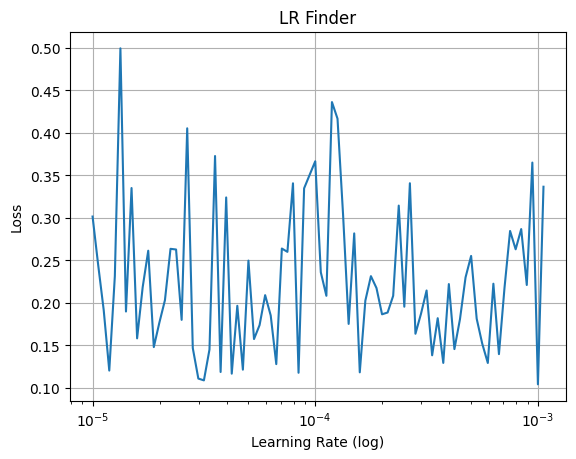

In [ ]:
print(f"Device: {device}")
lrs, losses = lrFinder(model, torch.optim.AdamW, TverskyLoss(), trainloaderWet, device,start_lr=1e-5,num_iter=200)

plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel("Learning Rate (log)")
plt.ylabel("Loss")
plt.title("LR Finder")
plt.grid()
plt.show()

## Training new model with data

In [ ]:
# load weights of base model in model to train
# model.load_state_dict(torch.load(BaseWeightWetPath, map_location=device))

In [81]:
# Test if with no weights, a better model can be achieved
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
        else:
            reset_weights(layer)  # aplica recursivamente

reset_weights(model)

In [82]:
model.train()

UNet(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (double_conv): Sequential(

In [83]:
#Train loop:
def get_accuracy(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    correct = (preds == targets).float().sum()
    total = torch.numel(preds)
    return correct / total

def get_jaccard(preds, targets, threshold=0.5, eps=1e-7):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + eps) / (union + eps)

def train_model(model, loss_function, optimizer, epochs, train_loader, test_loader, device,patience=5, save_path=None):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        #train_acc = 0.0
        train_jaccard = 0.0
        n_train = 0

        for imgs, masks in train_loader:
            imgs = imgs.to(device).float()
            masks = masks.to(device).float()
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_function(outputs, masks)
            loss.backward()
            optimizer.step()
            batch_size = imgs.size(0)
            train_loss += loss.item() * batch_size
            #train_acc += get_accuracy(outputs, masks) * batch_size
            train_jaccard += get_jaccard(outputs, masks) * batch_size
            n_train += batch_size

        train_loss /= n_train
        #train_acc /= n_train
        train_jaccard /= n_train
        train_losses.append(train_loss)
        #train_accuracies.append(train_acc.cpu().item())
        train_accuracies.append(train_jaccard.cpu().item())

        model.eval()
        test_loss = 0.0
        #test_acc = 0.0
        test_jaccard = 0.0
        n_test = 0
        with torch.no_grad():
            for imgs, masks in test_loader:
                imgs = imgs.to(device).float()
                masks = masks.to(device).float()
                outputs = model(imgs)
                loss = loss_function(outputs, masks)
                batch_size = imgs.size(0)
                test_loss += loss.item() * batch_size
                #test_acc += get_accuracy(outputs, masks) * batch_size
                test_jaccard += get_jaccard(outputs, masks) * batch_size
                n_test += batch_size

        test_loss /= n_test
        #test_acc /= n_test
        test_jaccard /= n_test
        test_losses.append(test_loss)
        #test_accuracies.append(test_acc.cpu().item())
        test_accuracies.append(test_jaccard.cpu().item())

        #print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {test_loss:.4f} - val_acc: {test_acc:.4f}")
        print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - acc: {train_jaccard:.4f} - val_loss: {test_loss:.4f} - val_acc: {test_jaccard:.4f}")

        if save_path is not None:
            # Early stopping
            if test_loss < best_loss:
                best_loss = test_loss
                patience_counter = 0
                torch.save(model.state_dict(), save_path)
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

    return train_losses, test_losses, train_accuracies, test_accuracies

In [ ]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
bestModel = os.path.join(weightsWetSeason, f"weights_{timestamp}.pth")
os.makedirs(os.path.dirname(bestModel), exist_ok=True)

In [85]:
bestModel

'/home/lcervantes/Dataset/Datasets/AndeanCrops/GreenSeason/Weights/weights_20251011_184431.pth'

In [86]:
print(device)

cuda:2


In [ ]:
# Entrenamiento
#criterion = BCEDiceLoss()
criterion = TverskyLoss(alpha=0.5, beta=0.5)
optimizer = optim.AdamW(model.parameters(), lr=0.001,weight_decay=1e-4)
epochs = 50

train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, criterion, optimizer, epochs, trainloaderWet, testloaderWet, device,patience = 10,save_path=bestModel
)

Epoch 1/50 - loss: 0.3990 - acc: 0.4622 - val_loss: 0.4052 - val_acc: 0.4459
Epoch 2/50 - loss: 0.3685 - acc: 0.4818 - val_loss: 0.3942 - val_acc: 0.4465
Epoch 3/50 - loss: 0.3535 - acc: 0.4909 - val_loss: 0.3836 - val_acc: 0.4577
Epoch 4/50 - loss: 0.3393 - acc: 0.5083 - val_loss: 0.3789 - val_acc: 0.4617
Epoch 5/50 - loss: 0.3334 - acc: 0.5157 - val_loss: 0.3787 - val_acc: 0.4680
Epoch 6/50 - loss: 0.3280 - acc: 0.5191 - val_loss: 0.3602 - val_acc: 0.4817
Epoch 7/50 - loss: 0.3127 - acc: 0.5402 - val_loss: 0.3526 - val_acc: 0.4931
Epoch 8/50 - loss: 0.3426 - acc: 0.5001 - val_loss: 0.3613 - val_acc: 0.4779
Epoch 9/50 - loss: 0.3164 - acc: 0.5313 - val_loss: 0.3603 - val_acc: 0.4837
Epoch 10/50 - loss: 0.3224 - acc: 0.5267 - val_loss: 0.3778 - val_acc: 0.4683
Epoch 11/50 - loss: 0.3129 - acc: 0.5358 - val_loss: 0.3448 - val_acc: 0.4993
Epoch 12/50 - loss: 0.2993 - acc: 0.5524 - val_loss: 0.3621 - val_acc: 0.4761
Epoch 13/50 - loss: 0.3171 - acc: 0.5296 - val_loss: 0.3503 - val_acc: 0.

In [88]:
def show_results(train_losses, test_losses, train_accuracies, test_accuracies):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(train_losses, label='train')
    ax1.plot(test_losses, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(train_accuracies, label='train')
    ax2.plot(test_accuracies, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    for ax in axes: ax.legend()

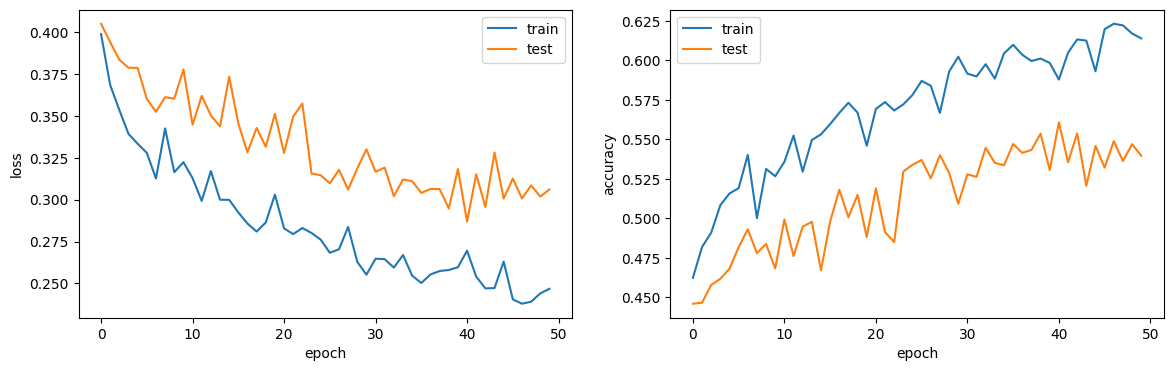

In [89]:
# Visualize
show_results(train_losses, test_losses, train_accuracies, test_accuracies)

In [90]:
predict_th = 0.5

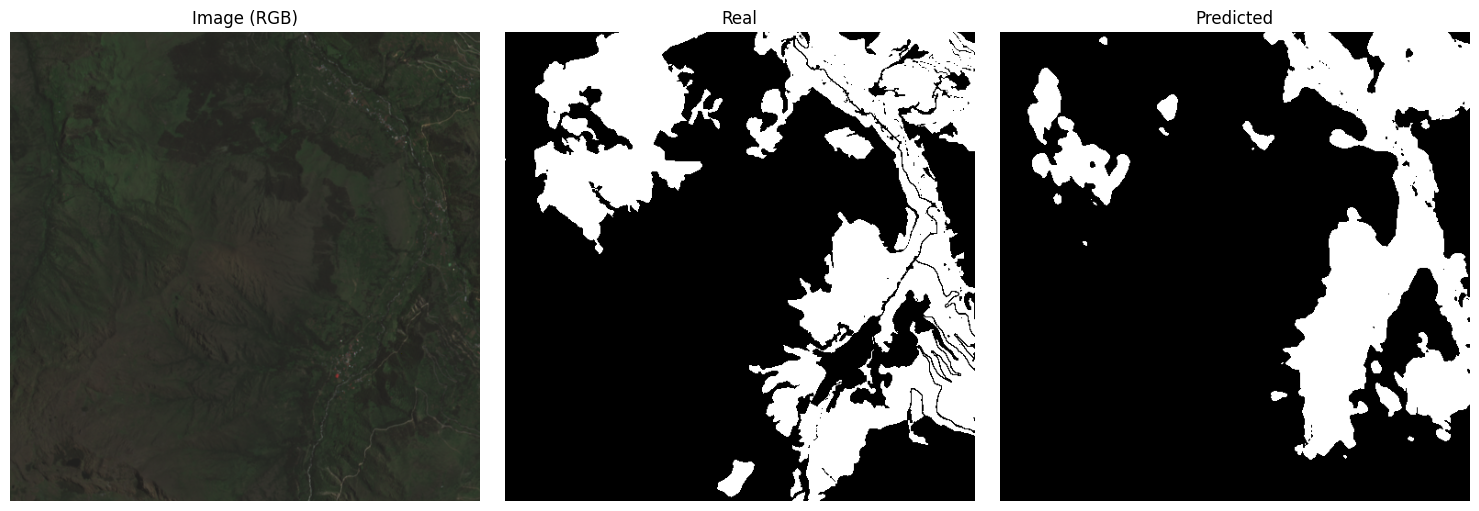

In [ ]:
# Eval and visualize
model.eval()
with torch.no_grad():
    imgs, masks = next(iter(testloaderWet))
    imgs = imgs.to(device)
    outputs = model(imgs)
    pred_mask = (outputs[0] > predict_th).float().squeeze().cpu().numpy()
    img = imgs[0].cpu().numpy().transpose(1, 2, 0)
    mask = masks[0].cpu().numpy().squeeze()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img[:, :, :3])
axs[0].set_title('Image (RGB)')
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Real')
axs[2].imshow(pred_mask, cmap='gray')
axs[2].set_title('Predicted')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

## Evaluation post - training

In [109]:
modelToEvalPath = "/home/lcervantes/Dataset/Datasets/AndeanCrops/WetSeason/Weights/AndeanCropModelModifiedWet.pth"
model.load_state_dict(torch.load(modelToEvalPath, map_location=device))

<All keys matched successfully>

In [110]:
device

device(type='cuda', index=2)

In [119]:
def compute_metrics(pred, target):
    pred = pred.cpu().numpy().astype(np.uint8).flatten()
    target = target.cpu().numpy().astype(np.uint8).flatten()

    jaccard = jaccard_score(target, pred, zero_division=0)
    precision = precision_score(target, pred, zero_division=0)
    recall = recall_score(target, pred, zero_division=0)
    dice = f1_score(target, pred, zero_division=0)

    return {
        "Jaccard": jaccard,
        "Dice": dice,
        "Precision": precision,
        "Recall": recall
    }

def compute_metrics_batch(pred, target):
    # pred y target: (batch, 1, H, W) or (batch, H, W)
    batch_size = pred.shape[0]
    results = {"Jaccard": [], "Dice": [], "Precision": [], "Recall": []}
    for i in range(batch_size):
        p = pred[i].cpu().numpy().astype(np.uint8).flatten()
        t = target[i].cpu().numpy().astype(np.uint8).flatten()
        results["Jaccard"].append(jaccard_score(t, p, zero_division=0))
        results["Dice"].append(f1_score(t, p, zero_division=0))
        results["Precision"].append(precision_score(t, p, zero_division=0))
        results["Recall"].append(recall_score(t, p, zero_division=0))
    # Average batch metrics

In [120]:
predict_th = 0.5

In [ ]:
metrics_list = []

model.eval()
with torch.no_grad():
    for img, mask in testloaderWet:
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        pred = (torch.sigmoid(output) > predict_th).float()

        metrics = compute_metrics(pred, mask)
        metrics_list.append(metrics)

In [122]:
print("Train Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Train Metrics
Jaccard: 0.5701
Dice: 0.7160
Precision: 0.6475
Recall: 0.8249


In [ ]:
metrics_list = []

model.eval()
with torch.no_grad():
    for img, mask in testloaderWet:
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        pred = (torch.sigmoid(output) > predict_th).float()

        metrics = compute_metrics(pred, mask)
        metrics_list.append(metrics)

In [124]:
print("Test Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Test Metrics
Jaccard: 0.5831
Dice: 0.7296
Precision: 0.6615
Recall: 0.8371


## Predictions

In [111]:
predictionsWetSeason

'/home/lcervantes/Dataset/Datasets/AndeanCrops/WetSeason/Predictions'

In [112]:
index = 0

for imgs, masks in testloaderWet:
    imgs = imgs.to(device)
    outputs = model(imgs)
    preds = (outputs > predict_th).float().cpu().numpy()

    for j in range(len(imgs)):
        img_path = testloaderWet.dataset.image_files[index]
        index += 1  # avanzar globalmente

        filename = os.path.basename(img_path)
        # Reemplazar sufijo (_p_f.tif o _p.tif)
        if filename.endswith('_p_f.tif'):
            filename = filename.replace('_p_f.tif', '_predicted.png')
        elif filename.endswith('_p.tif'):
            filename = filename.replace('_p.tif', '_predicted.png')
        else:
            filename = filename.replace('.tif', '_predicted.png')

        out_path = os.path.join(predictionsWetSeason, filename)

        pred_mask = (preds[j][0] * 255).astype(np.uint8)
        Image.fromarray(pred_mask).save(out_path)

In [113]:
masksWetSeason

'/home/lcervantes/Dataset/Datasets/AndeanCrops/WetSeason/Masks'

In [114]:
# Archivo CSV de salida
output_csv = "/home/lcervantes/Dataset/Datasets/AndeanCrops/WetSeason/WetSeasonReport.csv"

# Crear CSV
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Nombre de archivo", "Area (original)", "Area (predicted)"])

    for pred_name in sorted(os.listdir(predictionsWetSeason)):
        if not pred_name.endswith("_predicted.png"):
            continue

        # Base name (no ext)
        base_name = pred_name.replace("_predicted.png", "")

        # Path
        pred_path = os.path.join(predictionsWetSeason, pred_name)
        mask_path = os.path.join(masksWetSeason, base_name + "_m.png")

        # Verify original mask exists
        if not os.path.exists(mask_path):
            print("No mask found for ", base_name)
            continue

        # Read imgs
        pred_img = np.array(Image.open(pred_path))
        mask_img = np.array(Image.open(mask_path))

        #count white pixels
        pred_pixels = np.sum(pred_img > 127)
        orig_pixels = np.sum(mask_img > 127)

        # Get area per pixel based on sat
        if base_name.startswith("PS"):
            pixel_area = 2.8 * 2.8  # m²
        elif base_name.startswith("S2"):
            pixel_area = 10 * 10  # m²
        else:
            pixel_area = 1.0  # por seguridad

        # calculate total agricultural area per tile
        area_pred = pred_pixels * pixel_area
        area_orig = orig_pixels * pixel_area

        # Output to csv
        if area_orig > 0:
            diff_pct = ((area_pred - area_orig) / area_orig) * 100
        else:
            diff_pct = 0

        writer.writerow([
            base_name,
            int(area_orig),
            int(area_pred),
            round(diff_pct, 2)
        ])

# Train and test - Dry Season

## Split

In [9]:
# Customized DS for TIFF images (4 bands) y binary masks
class FourBandSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, files_list=None):
        if files_list is not None:
            self.image_files = files_list[0]
            self.mask_files = files_list[1]
        else:
            self.image_files = sorted(glob.glob(images_dir + "/*.tif"))
            self.mask_files = sorted(glob.glob(masks_dir + "/*.png"))
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        # 4 bands image
        with rasterio.open(self.image_files[idx]) as src:
            img = src.read()  # (bands, H, W)
            img = np.transpose(img, (1, 2, 0)).astype(np.float32)
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            img = np.transpose(img, (2, 0, 1))  # (4, H, W)
        # Mask
        mask = Image.open(self.mask_files[idx]).convert('L')
        mask = np.array(mask)
        mask = (mask > 0).astype(np.float32)
        mask = np.expand_dims(mask, axis=0)  # (1, H, W)
        return torch.from_numpy(img), torch.from_numpy(mask)

In [7]:
imageDry = sorted(glob.glob(imagesDrySeason + "/*.tif"))
maskDry = sorted(glob.glob(masksDrySeason + "/*.png"))
trainTilesDry, testTilesDry, trainDryMasks, testDryMasks = train_test_split(
    imageDry, maskDry, test_size=0.3, random_state=42
)

In [10]:
trainDryDS = FourBandSegmentationDataset(imagesDrySeason, masksDrySeason, files_list=(trainTilesDry, trainDryMasks))
testDryDS = FourBandSegmentationDataset(imagesDrySeason, masksDrySeason, files_list=(testTilesDry, testDryMasks))

In [11]:
batch_size = 4
trainloaderDry = DataLoader(trainDryDS, batch_size=batch_size, shuffle=True)
testloaderDry = DataLoader(testDryDS, batch_size=batch_size, shuffle=True)

In [12]:
len(trainDryDS),len(testDryDS)

(287, 123)

## Load of base model - dry

In [13]:
inputBands = 4
outputBands=1

In [19]:
# Unet and Def
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels,dropout=0.0):
        super().__init__()
        if dropout > 0.0:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout)
            )
        else:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
    def forward(self, x):
        return self.double_conv(x)

In [14]:
class UNetDry(nn.Module):
    def __init__(self, in_channels=inputBands, out_channels=outputBands):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024,dropout=0.05)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512,dropout=0.1)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256,dropout=0.1)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128,dropout=0.1)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64,dropout=0.1)
        self.conv_last = nn.Conv2d(64, out_channels, 1)
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        bottleneck = self.bottleneck(self.pool(enc4))
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        #return torch.sigmoid(self.conv_last(dec1))
        return self.conv_last(dec1) # No sigmoid here, we will apply it in the loss function

In [15]:
#Losses:

def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(1,2,3))
    loss = 1 - ((2. * intersection + smooth) / (pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + smooth))
    return loss.mean()

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)

        # Dice
        smooth = 1e-6
        inputs = torch.sigmoid(inputs)
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)

        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)

        return 0.5 * bce_loss + 0.5 * dice_loss
    
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1e-6):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        TP = (inputs * targets).sum()
        FP = ((1 - targets) * inputs).sum()
        FN = (targets * (1 - inputs)).sum()

        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        return 1 - tversky

In [16]:
#list gpus available and its uuids
dc = torch.cuda.device_count()
print("Device count: " +  str(dc))
for i in range(dc):
    print("Device " + str(i) + ": " + str(torch.cuda.get_device_properties(i).uuid))

Device count: 3
Device 0: 8dd8bd39-a66b-8aa3-ce58-81c5e214a054
Device 1: 0d143765-9b0e-0a6a-0f03-2a9a43a39889
Device 2: cd01c66c-b823-0ed5-f79c-20e623459232


In [17]:
print(torch.cuda.is_available())
device = torch.device(2 if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

True
Device: cuda:2


In [21]:
modelDry = UNetDry(in_channels=inputBands, out_channels=outputBands).to(device)
criterion = TverskyLoss(alpha=0.5, beta=0.5)
optimizer = optim.AdamW(modelDry.parameters(), lr=0.001,weight_decay=1e-4)
epochs = 20

In [24]:
modelDry.load_state_dict(torch.load(BaseWeightDryPath, map_location=device))

<All keys matched successfully>

## Test pre-training

In [25]:
def compute_metrics(pred, target):
    pred = pred.cpu().numpy().astype(np.uint8).flatten()
    target = target.cpu().numpy().astype(np.uint8).flatten()

    jaccard = jaccard_score(target, pred, zero_division=0)
    precision = precision_score(target, pred, zero_division=0)
    recall = recall_score(target, pred, zero_division=0)
    dice = f1_score(target, pred, zero_division=0)

    return {
        "Jaccard": jaccard,
        "Dice": dice,
        "Precision": precision,
        "Recall": recall
    }

def compute_metrics_batch(pred, target):
    # pred y target: (batch, 1, H, W) or (batch, H, W)
    batch_size = pred.shape[0]
    results = {"Jaccard": [], "Dice": [], "Precision": [], "Recall": []}
    for i in range(batch_size):
        p = pred[i].cpu().numpy().astype(np.uint8).flatten()
        t = target[i].cpu().numpy().astype(np.uint8).flatten()
        results["Jaccard"].append(jaccard_score(t, p, zero_division=0))
        results["Dice"].append(f1_score(t, p, zero_division=0))
        results["Precision"].append(precision_score(t, p, zero_division=0))
        results["Recall"].append(recall_score(t, p, zero_division=0))
    # Average batch metrics
    return {k: np.mean(v) for k, v in results.items()}

In [26]:
predict_th = 0.5

In [28]:
metrics_list = []

modelDry.eval()
with torch.no_grad():
    for img, mask in trainloaderDry:
        img, mask = img.to(device), mask.to(device)
        output = modelDry(img)
        pred = (torch.sigmoid(output) > predict_th).float()
        metrics = compute_metrics_batch(pred, mask)
        metrics_list.append(metrics)

In [29]:
print("Train Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Train Metrics
Jaccard: 0.3725
Dice: 0.5070
Precision: 0.5233
Recall: 0.6090


In [30]:
metrics_list = []

modelDry.eval()
with torch.no_grad():
    for img, mask in testloaderDry:
        img, mask = img.to(device), mask.to(device)
        output = modelDry(img)
        pred = (torch.sigmoid(output) > predict_th).float()
        metrics = compute_metrics_batch(pred, mask)
        metrics_list.append(metrics)

In [31]:
print("Test Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Test Metrics
Jaccard: 0.3767
Dice: 0.5034
Precision: 0.5595
Recall: 0.5717


## Training

In [33]:
modelDry.train()

UNetDry(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (double_conv): Sequenti

In [34]:
#Train loop:
def get_accuracy(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    correct = (preds == targets).float().sum()
    total = torch.numel(preds)
    return correct / total

def get_jaccard(preds, targets, threshold=0.5, eps=1e-7):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + eps) / (union + eps)

def train_model(model, loss_function, optimizer, epochs, train_loader, test_loader, device,patience=5, save_path=None):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        #train_acc = 0.0
        train_jaccard = 0.0
        n_train = 0

        for imgs, masks in train_loader:
            imgs = imgs.to(device).float()
            masks = masks.to(device).float()
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_function(outputs, masks)
            loss.backward()
            optimizer.step()
            batch_size = imgs.size(0)
            train_loss += loss.item() * batch_size
            #train_acc += get_accuracy(outputs, masks) * batch_size
            train_jaccard += get_jaccard(outputs, masks) * batch_size
            n_train += batch_size

        train_loss /= n_train
        #train_acc /= n_train
        train_jaccard /= n_train
        train_losses.append(train_loss)
        #train_accuracies.append(train_acc.cpu().item())
        train_accuracies.append(train_jaccard.cpu().item())

        model.eval()
        test_loss = 0.0
        #test_acc = 0.0
        test_jaccard = 0.0
        n_test = 0
        with torch.no_grad():
            for imgs, masks in test_loader:
                imgs = imgs.to(device).float()
                masks = masks.to(device).float()
                outputs = model(imgs)
                loss = loss_function(outputs, masks)
                batch_size = imgs.size(0)
                test_loss += loss.item() * batch_size
                #test_acc += get_accuracy(outputs, masks) * batch_size
                test_jaccard += get_jaccard(outputs, masks) * batch_size
                n_test += batch_size

        test_loss /= n_test
        #test_acc /= n_test
        test_jaccard /= n_test
        test_losses.append(test_loss)
        #test_accuracies.append(test_acc.cpu().item())
        test_accuracies.append(test_jaccard.cpu().item())

        #print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {test_loss:.4f} - val_acc: {test_acc:.4f}")
        print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - jacc: {train_jaccard:.4f} - val_loss: {test_loss:.4f} - val_jacc: {test_jaccard:.4f}")

        if save_path is not None:
            # Early stopping
            if test_loss < best_loss:
                best_loss = test_loss
                patience_counter = 0
                torch.save(model.state_dict(), save_path)
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

    return train_losses, test_losses, train_accuracies, test_accuracies

In [35]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
bestModelDry = os.path.join(weightsDrySeason, f"weights_{timestamp}.pth")
os.makedirs(os.path.dirname(bestModelDry), exist_ok=True)


In [36]:
bestModelDry

'/home/lcervantes/Dataset/Datasets/AndeanCrops/DrySeason/Weights/weights_20251013_095741.pth'

In [37]:
print(device)

cuda:2


In [38]:
# Entrenamiento
#criterion = BCEDiceLoss()
criterion = TverskyLoss(alpha=0.5, beta=0.5)
optimizer = optim.AdamW(modelDry.parameters(), lr=0.001,weight_decay=1e-4)
epochs = 20

In [39]:
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    modelDry, criterion, optimizer, epochs, trainloaderDry, testloaderDry, device,patience = 5,save_path=bestModelDry
)

Epoch 1/20 - loss: 0.2968 - jacc: 0.5574 - val_loss: 0.2749 - val_jacc: 0.5781
Epoch 2/20 - loss: 0.2851 - jacc: 0.5686 - val_loss: 0.3446 - val_jacc: 0.4966
Epoch 3/20 - loss: 0.2551 - jacc: 0.6078 - val_loss: 0.2593 - val_jacc: 0.6020
Epoch 4/20 - loss: 0.2549 - jacc: 0.6040 - val_loss: 0.2561 - val_jacc: 0.6029
Epoch 5/20 - loss: 0.2436 - jacc: 0.6213 - val_loss: 0.2495 - val_jacc: 0.6169
Epoch 6/20 - loss: 0.2446 - jacc: 0.6201 - val_loss: 0.2530 - val_jacc: 0.6179
Epoch 7/20 - loss: 0.2788 - jacc: 0.5765 - val_loss: 0.3064 - val_jacc: 0.5525
Epoch 8/20 - loss: 0.2552 - jacc: 0.6071 - val_loss: 0.2617 - val_jacc: 0.6012
Epoch 9/20 - loss: 0.2520 - jacc: 0.6133 - val_loss: 0.2478 - val_jacc: 0.6166
Epoch 10/20 - loss: 0.2438 - jacc: 0.6239 - val_loss: 0.2537 - val_jacc: 0.6083
Epoch 11/20 - loss: 0.2409 - jacc: 0.6257 - val_loss: 0.2770 - val_jacc: 0.5880
Epoch 12/20 - loss: 0.2387 - jacc: 0.6287 - val_loss: 0.2431 - val_jacc: 0.6176
Epoch 13/20 - loss: 0.2293 - jacc: 0.6386 - val_l

In [41]:
def show_results(train_losses, test_losses, train_accuracies, test_accuracies):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(train_losses, label='train')
    ax1.plot(test_losses, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(train_accuracies, label='train')
    ax2.plot(test_accuracies, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    for ax in axes: ax.legend()

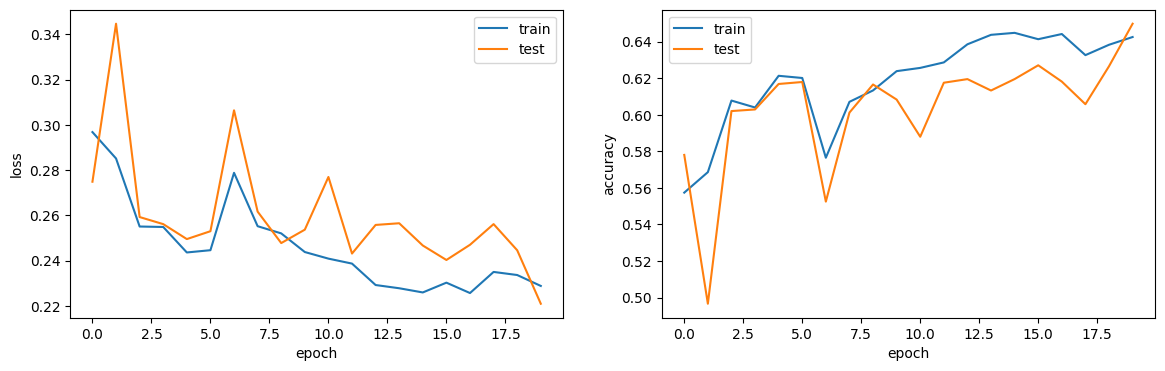

In [42]:
# Visualize
show_results(train_losses, test_losses, train_accuracies, test_accuracies)

In [43]:
predict_th = 0.5

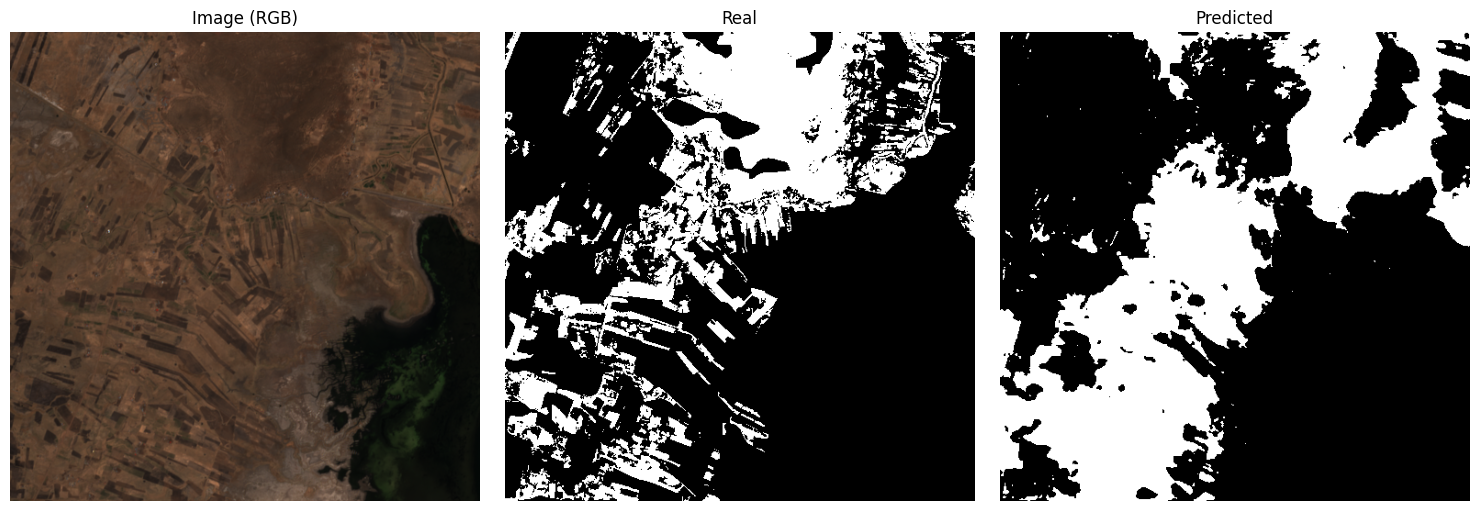

In [50]:
# Eval and visualize
modelDry.eval()
with torch.no_grad():
    imgs, masks = next(iter(testloaderDry))
    imgs = imgs.to(device)
    outputs = modelDry(imgs)
    pred_mask = (outputs[0] > predict_th).float().squeeze().cpu().numpy()
    img = imgs[0].cpu().numpy().transpose(1, 2, 0)
    mask = masks[0].cpu().numpy().squeeze()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img[:, :, :3])
axs[0].set_title('Image (RGB)')
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Real')
axs[2].imshow(pred_mask, cmap='gray')
axs[2].set_title('Predicted')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

## Metrics

In [ ]:
modelToEvalPath = "/home/lcervantes/Dataset/Datasets/AndeanCrops/DrySeason/Weights/AndeanCropModelModifiedDry.pth"
modelDry.load_state_dict(torch.load(modelToEvalPath, map_location=device))

<All keys matched successfully>

In [52]:
device

device(type='cuda', index=2)

In [53]:
def compute_metrics(pred, target):
    pred = pred.cpu().numpy().astype(np.uint8).flatten()
    target = target.cpu().numpy().astype(np.uint8).flatten()

    jaccard = jaccard_score(target, pred, zero_division=0)
    precision = precision_score(target, pred, zero_division=0)
    recall = recall_score(target, pred, zero_division=0)
    dice = f1_score(target, pred, zero_division=0)

    return {
        "Jaccard": jaccard,
        "Dice": dice,
        "Precision": precision,
        "Recall": recall
    }

def compute_metrics_batch(pred, target):
    # pred y target: (batch, 1, H, W) or (batch, H, W)
    batch_size = pred.shape[0]
    results = {"Jaccard": [], "Dice": [], "Precision": [], "Recall": []}
    for i in range(batch_size):
        p = pred[i].cpu().numpy().astype(np.uint8).flatten()
        t = target[i].cpu().numpy().astype(np.uint8).flatten()
        results["Jaccard"].append(jaccard_score(t, p, zero_division=0))
        results["Dice"].append(f1_score(t, p, zero_division=0))
        results["Precision"].append(precision_score(t, p, zero_division=0))
        results["Recall"].append(recall_score(t, p, zero_division=0))
    # Average batch metrics

In [54]:
predict_th = 0.5

In [56]:
metrics_list = []

modelDry.eval()
with torch.no_grad():
    for img, mask in trainloaderDry:
        img, mask = img.to(device), mask.to(device)
        output = modelDry(img)
        pred = (torch.sigmoid(output) > predict_th).float()

        metrics = compute_metrics(pred, mask)
        metrics_list.append(metrics)

In [57]:
print("Train Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Train Metrics
Jaccard: 0.6632
Dice: 0.7908
Precision: 0.7564
Recall: 0.8382


In [58]:
modelDry.eval()
with torch.no_grad():
    for img, mask in testloaderDry:
        img, mask = img.to(device), mask.to(device)
        output = modelDry(img)
        pred = (torch.sigmoid(output) > predict_th).float()

        metrics = compute_metrics(pred, mask)
        metrics_list.append(metrics)

In [59]:
print("Test Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Test Metrics
Jaccard: 0.6588
Dice: 0.7865
Precision: 0.7507
Recall: 0.8373


## Predictions

In [72]:
predictionsDrySeason

'/home/lcervantes/Dataset/Datasets/AndeanCrops/DrySeason/Predictions'

In [75]:
index = 0

for imgs, masks in testloaderDry:
    imgs = imgs.to(device)
    outputs = modelDry(imgs)
    preds = (outputs > predict_th).float().cpu().numpy()

    for j in range(len(imgs)):
        img_path = testloaderDry.dataset.image_files[index]
        index += 1  # avanzar globalmente

        filename = os.path.basename(img_path)
        # Reemplazar sufijo (_p_f.tif o _p.tif)
        if filename.endswith('_p_f.tif'):
            filename = filename.replace('_p_f.tif', '_predicted.png')
        elif filename.endswith('_p.tif'):
            filename = filename.replace('_p.tif', '_predicted.png')
        else:
            filename = filename.replace('.tif', '_predicted.png')

        out_path = os.path.join(predictionsDrySeason, filename)

        pred_mask = (preds[j][0] * 255).astype(np.uint8)
        Image.fromarray(pred_mask).save(out_path)

In [ ]:
masksDrySeason

'/home/lcervantes/Dataset/Datasets/AndeanCrops/DrySeason/Masks'

In [ ]:
# Archivo CSV de salida
output_csv = "/home/lcervantes/Dataset/Datasets/AndeanCrops/DrySeason/DrySeasonReport.csv"

# Crear CSV
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Nombre de archivo", "Area (original)", "Area (predicted)"])

    for pred_name in sorted(os.listdir(predictionsDrySeason)):
        if not pred_name.endswith("_predicted.png"):
            continue

        # Base name (no ext)
        base_name = pred_name.replace("_predicted.png", "")

        # Path
        pred_path = os.path.join(predictionsDrySeason, pred_name)
        mask_path = os.path.join(masksDrySeason, base_name + "_m.png")

        # Verify original mask exists
        if not os.path.exists(mask_path):
            print("No mask found for ", base_name)
            continue

        # Read imgs
        pred_img = np.array(Image.open(pred_path))
        mask_img = np.array(Image.open(mask_path))

        #count white pixels
        pred_pixels = np.sum(pred_img > 127)
        orig_pixels = np.sum(mask_img > 127)

        # Get area per pixel based on sat
        if base_name.startswith("PS"):
            pixel_area = 2.8 * 2.8  # m²
        elif base_name.startswith("S2"):
            pixel_area = 10 * 10  # m²
        else:
            pixel_area = 1.0  # por seguridad

        # calculate total agricultural area per tile
        area_pred = pred_pixels * pixel_area
        area_orig = orig_pixels * pixel_area

        # Output to csv
        if area_orig > 0:
            diff_pct = ((area_pred - area_orig) / area_orig) * 100
        else:
            diff_pct = 0

        writer.writerow([
            base_name,
            int(area_orig),
            int(area_pred),
            round(diff_pct, 2)
        ])